In [1]:
### IMPORTING PACKAGES ###
import numpy as np
import matplotlib.pyplot as plt
import csv
import timeit
start = timeit.default_timer()

In [2]:
### CONSTANTS ###
rho_et = 0.78
rho_w = 0.997
Mm_et = 46
Mm_w = 18
steps_exp = 15
d = 0.07
area = (np.pi/4) * d**2

[0.62880584 0.72700352 0.80111487 0.75149351 0.69638814 0.77164012
 0.72685466 0.75545159 0.72411818 0.71562994 0.83445098 0.83599818]


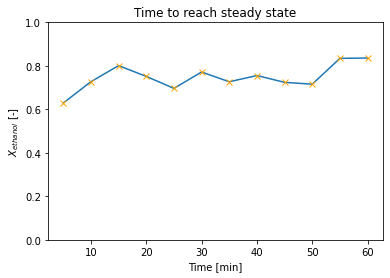

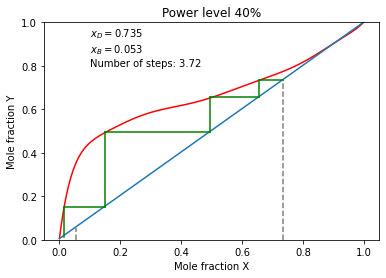


Power level: 40 
Theoretical steps: 3.7205882352941178 
Column effieciency: 0.18137254901960784


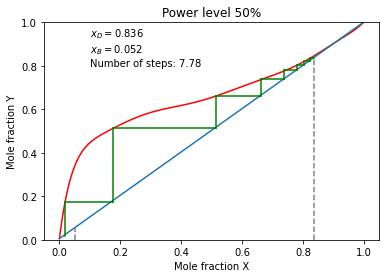


Power level: 50 
Theoretical steps: 7.7834394904458595 
Column effieciency: 0.4522292993630573


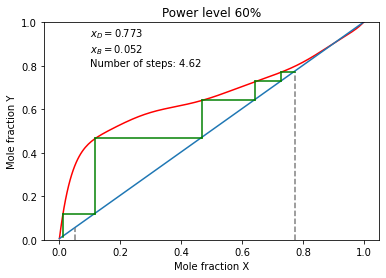


Power level: 60 
Theoretical steps: 4.616822429906542 
Column effieciency: 0.24112149532710284


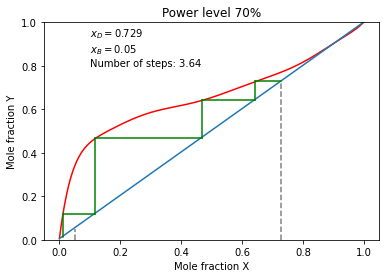


Power level: 70 
Theoretical steps: 3.635514018691589 
Column effieciency: 0.17570093457943925


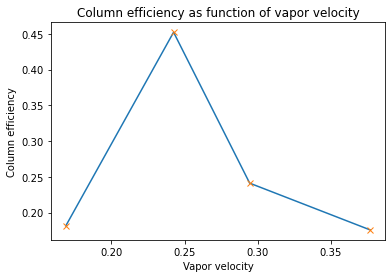

[0.16889912 0.24252182 0.29449078 0.37677497]
Run time: 10.44966379999994


In [3]:
### GET VLE REGRESSION ###
def get_VLE_regression():
    vle_x = np.array([])
    vle_y = np.array([])

    with open("VLE-data.csv", newline="") as f:
        reader = csv.reader(f)
        data = list(reader)
        for i in range(2, len(data)):
            for j in range(len(data[i])):
                if j == 1:
                    vle_x = np.append(vle_x, float(data[i][j]))
                elif j == 2:
                    vle_y = np.append(vle_y, float(data[i][j]))
    
    x = np.linspace(0, 1, num=201)
    y = np.array([])
    coeff = np.polyfit(vle_x, vle_y, 9)
    for i in range(len(x)):
        y = np.append(y, calc_y(coeff, x[i]))
    return x, y, coeff


### CALCULATE Y USING DEFINITION ###
def calc_y(coeff, x):
    y = 0
    for i in range(len(coeff)):
        y += coeff[i] * x ** (len(coeff) - 1 - i)
    return y


### CALCULATE X BY BRUTE FORCE ### 
def calc_x(coeff, y):
    x_guess = 0
    tol = 1
    while tol > 0.002:
        y_guess = calc_y(coeff, x_guess)
        tol = abs(y - y_guess)
        x_guess += 0.0002
    return round(x_guess - 0.0005, 3) 


### CONVERT VOL% TO MOLE FRACTION ###
def vol_to_molefrac(vol):
    x = vol / (vol + (100-vol)*((rho_w*Mm_et)/(rho_et*Mm_w)))
    return x


### DRAW MCCABE-THIELE DIAGRAM ###
def draw_mccabe(x_d, x_b, coeff, power):
    plt.plot(vle_x, vle_y, color="red")         
    plt.plot([vle_x[0], vle_x[-1]], [vle_y[0], vle_y[-1]])
    plt.ylim(0, 1)
    plt.xlabel("Mole fraction X")
    plt.ylabel("Mole fraction Y")
    str_title = "Power level " + str(power) + "%"
    plt.title(str_title)
    
    steps = 0
    x_1 = x_d
    y_1 = x_d
    plt.plot([x_d, x_d], [0, x_d], "--", color="grey")
    plt.plot([x_b, x_b], [0, x_b], "--", color="grey")
    
    x_2 = 1
    while x_2 > x_b:
        # Horisontal line
        x_2 = calc_x(coeff, y_1)
        plt.plot([x_1, x_2], [y_1, y_1], color="green")
        
        # Vertical line
        y_2 = x_2
        plt.plot([x_2, x_2], [y_1, y_2], color="green")
        
        if (x_2 < x_b):
            steps += (x_1 - x_b) / (x_1 - x_2)
        else:
            steps += 1
            x_1 = x_2
            y_1 = y_2
            
    str_steps = "$x_{D}=$" + str(x_d) + "\n$x_{B}=$" + str(x_b) + \
                "\nNumber of steps: " + str(round(steps, 2)) 
    str_filename = "Power_level_" + str(power)
    plt.text(0.1, 0.8, str_steps)
    plt.savefig(str_filename, dpi=500)
    plt.show()
    print("\nPower level:", power, "\nTheoretical steps:", steps, \
          "\nColumn effieciency:", (steps - 1)/steps_exp)
    return steps
        
            
### DATA FROM EXERCISE 1 ###
time = np.linspace(5, 60, num=12)
volume_percent = np.array([84.545, 89.583, 92.861, 90.711, 88.105, 91.605, \
                           89.576, 90.889, 89.447, 89.043, 94.212, 94.273])


### PLOTTING EXERCISE 1 RESIDENCE TIME ###
def ex1():
    molefrac = vol_to_molefrac(volume_percent)
    print(molefrac)
    plt.plot(time, molefrac)
    plt.plot(time, molefrac,"x", color="orange")
    plt.title("Time to reach steady state")
    plt.xlabel("Time [min]")
    plt.ylabel("$X_{ethanol}$ [-]")
    plt.yticks([0, 0.2, 0.4 ,0.6, 0.8, 1])
    plt.savefig("Steady_state_time", dpi=500)
    plt.show()


### DATA FROM EXERCISE 2 ###
# Top composition, bottom composition, power level, flow rate
run1 = [89.935, 15.314, 40, 39]
run2 = [94.273, 14.926, 50, 56]
run3 = [91.643, 14.986, 60, 68]
run4 = [89.677, 14.509, 70, 87]
run_tot = [run1, run2, run3, run4]


### PLOTTING EXERCISE 2 MCCABE AND VAPOR VELOCITY ###
vle_x, vle_y, coeff = get_VLE_regression()
def ex2():
    vapor_vel = np.array([])
    efficiency = np.array([])
    for run in run_tot:
        x_d = round(vol_to_molefrac(run[0]), 3)
        x_b = round(vol_to_molefrac(run[1]), 3)
        steps = draw_mccabe(x_d, x_b, coeff, run[2])
        vapor_vel = np.append(vapor_vel, run[3]/(area*1000*60))
        efficiency = np.append(efficiency, (steps - 1)/steps_exp)
    plt.plot(vapor_vel, efficiency)
    plt.plot(vapor_vel, efficiency, "x")
    plt.xlabel("Vapor velocity")
    plt.ylabel("Column efficiency")
    plt.title("Column efficiency as function of vapor velocity")
    plt.savefig("Vapor_velocity", dpi=500)
    plt.show()
    print(vapor_vel)
    
### MAIN ###       
ex1()
ex2()
stop = timeit.default_timer()
print("Run time:", stop - start)